# Maize NMM RNAseq Salmon Analysis

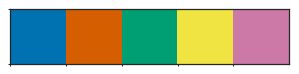

In [2]:
import sys
import os
from glob import glob
import re

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib_venn as vn
import seaborn as sns
from scipy.optimize import curve_fit

import rpy2.robjects as robj

%load_ext rpy2.ipython
robj.pandas2ri.activate()

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

[ 138.10884499   43.1707951    85.94507796]
[ 137.20729825   39.28552794   93.73495352]
[ 134.80588407   38.98388076   94.66000071]
[ 131.61384828   34.84281907  104.94168199]
[ 135.94090529   40.37268303   91.13470361]
[ 127.89000948   35.18221784  104.13766978]


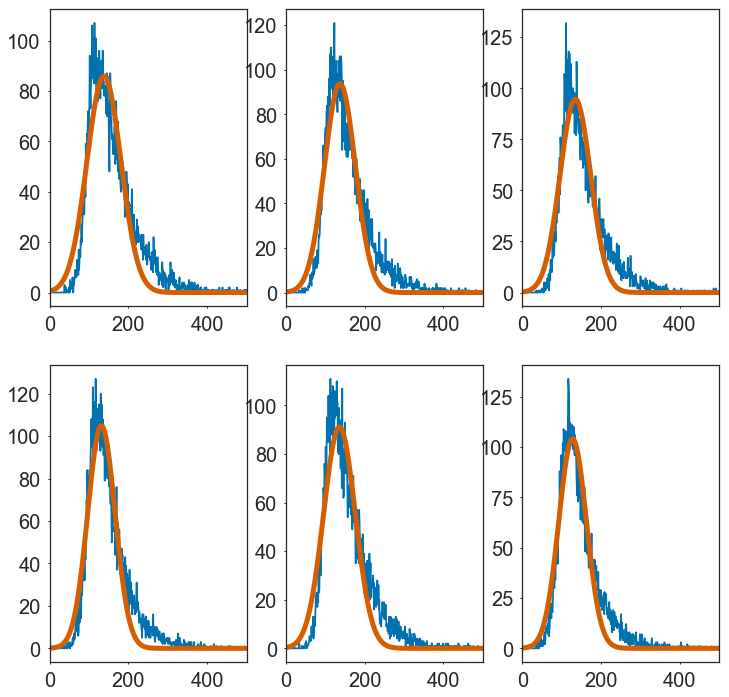

In [2]:
def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu) ** 2 / 2 / sigma ** 2)


fig, axes = plt.subplots(figsize=(12, 12), nrows=2, ncols=3)
for fn, ax in zip(glob('ERR*/aux_info/fld'), axes.ravel()):
    y = np.fromfile(fn, dtype=np.int32)
    exp = (250, 50, 35)
    params, _ = curve_fit(gauss, np.arange(len(y)), y, exp)
    print(params)
    ax.plot(y)
    ax.plot(gauss(np.arange(500), *params), lw=5)
    ax.set_xlim(0, 500)
plt.show()

In [3]:
%%R
library(biomaRt)
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRblas.so
LAPACK: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] biomaRt_2.34.2

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.15         IRanges_2.12.0       XML_3.98-1.6        
 [4] prettyunits_1.0.2    assertthat_0.2.0     digest_0.6.12       
 [7] bitops_1.0-6         R6_

In [243]:
%%R -o zm_orthologs,zm_tx2gene_bio
library(biomaRt)
dataset = useMart(biomart='plants_mart', host='plants.ensembl.org', dataset='zmays_eg_gene')
zm_orthologs = getBM(mart=dataset,
                     attributes=c('ensembl_gene_id',
                                  'athaliana_eg_homolog_ensembl_gene',
                                  'athaliana_eg_homolog_orthology_type'))
zm_tx2gene_bio = getBM(mart=dataset,
                       attributes=c('ensembl_transcript_id',
                                    'ensembl_gene_id',
                                    'transcript_length',
                                    'transcript_biotype'))

In [264]:
zm_biotype_go = (zm_tx2gene_bio.groupby('ensembl_gene_id')
                               .agg({'transcript_length': 'median',
                                     'transcript_biotype': 'first'}))
display(zm_biotype_go.head())
zm_tx2gene = zm_tx2gene_bio[['ensembl_transcript_id', 'ensembl_gene_id']]
zm_orthologs = zm_orthologs.set_index('ensembl_gene_id').join(zm_biotype_go).reset_index()
zm_orthologs.head()

,transcript_biotype,transcript_length
ensembl_gene_id,,
ENSRNA049437471,tRNA,74.0
ENSRNA049437473,tRNA,72.0
ENSRNA049437518,tRNA,74.0
ENSRNA049437544,tRNA,73.0
ENSRNA049437607,tRNA,72.0


,ensembl_gene_id,athaliana_eg_homolog_ensembl_gene,athaliana_eg_homolog_orthology_type,transcript_biotype,transcript_length
0,ENSRNA049437471,,,tRNA,74.0
1,ENSRNA049437473,,,tRNA,72.0
2,ENSRNA049437518,,,tRNA,74.0
3,ENSRNA049437544,,,tRNA,73.0
4,ENSRNA049437607,,,tRNA,72.0


In [245]:
%%R -i zm_tx2gene
library(stringr)
library(tximport)
library(edgeR)
files <- Sys.glob('ERR*/quant.sf')
names(files) <- str_split_fixed(str_split_fixed(files, "/", 2)[,1], "_", 2)[,1]
salmon.gene <- tximport(files,
                        type="salmon",
                        tx2gene=zm_tx2gene)

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: reading in files with read.delim (install 'readr' package for speed up)

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 3 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 4 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 5 
  warnings.warn(x,

In [246]:
%%R
sample_groups <- factor(c('NMM', 'NMM', 'NMM', 'CNTRL', 'CNTRL', 'CNTRL'))
design <- model.matrix(~0 + sample_groups)
rownames(design) <- names(files)
colnames(design) <- levels(sample_groups)
design

           CNTRL NMM
ERR2193270     0   1
ERR2193271     0   1
ERR2193272     0   1
ERR2193273     1   0
ERR2193274     1   0
ERR2193275     1   0
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$sample_groups
[1] "contr.treatment"



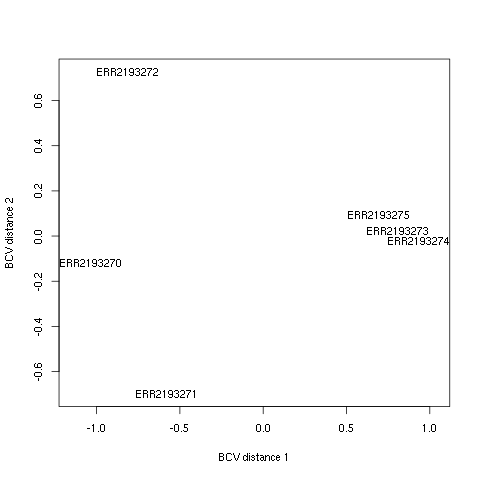

In [247]:
%%R
counts = salmon.gene$counts
len = salmon.gene$length
normMat <- len/exp(rowMeans(log(len)))
o <- log(calcNormFactors(counts/normMat)) + log(colSums(counts/normMat))
y <- DGEList(counts)
y$offset <- t(t(log(normMat)) + o)
keep <- rowSums(cpm(y) > 1) >= 2
y <- y[keep, , keep.lib.sizes=FALSE]
plotMDS(y, method='bcv', top=200)

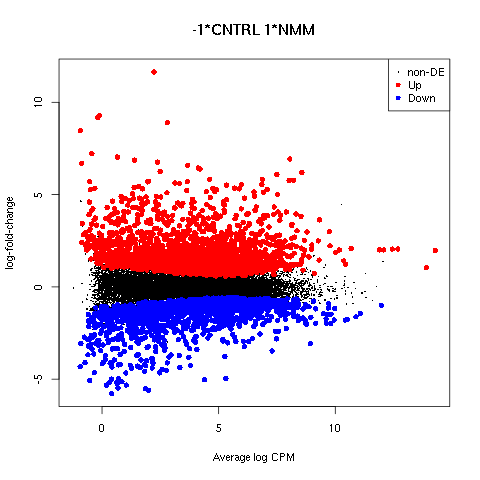

In [248]:
%%R
y <- estimateDisp(y, design=design)
fit <- glmFit(y, design)
nmm_v_cntrl <- glmLRT(fit,
                      contrast=makeContrasts('NMM - CNTRL', levels=design))
plotMD(nmm_v_cntrl)

In [270]:
%%R -o nmm

library(oligo)
library(puma)

load('/home/matthew/Documents/analysis_notebooks/tair10_nmm_6h_24h/data/puma_objects.rdata')
e <- exprs(combined)
p <- statistic(pplrs)
f <- as(getNetAffx(normalised, 'transcript'), 'data.frame')[c(9, 18)]
nmm <- merge(f, merge(e, p, by=0), by.x=0, by.y='Row.names')
nmm <- nmm[nmm['category'] == 'main',]
nmm['logFC_NMM_6h_vs_DMSO_6h'] <- nmm['NMM_6h'] - nmm['DMSO_6h']
nmm['logFC_NMM_24h_vs_DMSO_24h'] <- nmm['NMM_24h'] - nmm['DMSO_24h']
nmm['logFC_NMM_24h_vs_NMM_6h'] <- nmm['NMM_24h'] - nmm['NMM_6h']
nmm['PPLR_NMM_6h_vs_DMSO_6h'] <- nmm['2_vs_1']
nmm['PPLR_NMM_24h_vs_DMSO_24h'] <- nmm['4_vs_3']
nmm['PPLR_NMM_24h_vs_NMM_6h'] <- nmm['4_vs_2']

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml

In [275]:
annot = nmm.mrnaassignment.str.split('\s+///\s+', expand=True)
annot = annot.where(
    annot.apply(lambda col: col.str.contains('ENSEMBL'), axis=0))
annot['probe_cluster_id'] = nmm['Row.names']
annot = pd.melt(annot, id_vars='probe_cluster_id')
annot = (annot.drop('variable', axis=1)
              .dropna()
              .sort_values('probe_cluster_id'))
annot = annot.join(
    annot.value.str.split('\s+//\s+', expand=True)[[0, 2]]
)
annot = annot.drop('value', axis=1)
annot.columns = ['probe_cluster_id', 'transcript_id', 'desc']
annot = annot.join(
    annot['desc'].str.split('\s*[a-z]+:', expand=True)[[2, 3, 5]],
)
annot = annot.drop('desc', axis=1)
annot.columns = [
    'probe_cluster_id', 'transcript_id', 'loc', 'gene_id_athaliana', 'description']
nmm_annot = annot.merge(
    nmm[['Row.names', 'DMSO_24h', 'DMSO_6h', 'NMM_24h', 'NMM_6h',
         'logFC_NMM_6h_vs_DMSO_6h', 'logFC_NMM_24h_vs_DMSO_24h', 
         'logFC_NMM_24h_vs_NMM_6h', 'PPLR_NMM_6h_vs_DMSO_6h',
         'PPLR_NMM_24h_vs_DMSO_24h', 'PPLR_NMM_24h_vs_NMM_6h']],
    left_on='probe_cluster_id',
    right_on='Row.names',
    how='left'
)
nmm_annot = nmm_annot.drop(['Row.names'], axis=1)
nmm_annot = nmm_annot.drop_duplicates(subset='gene_id_athaliana')
nmm_annot.head()

,probe_cluster_id,transcript_id,loc,gene_id_athaliana,description,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,logFC_NMM_24h_vs_DMSO_24h,logFC_NMM_24h_vs_NMM_6h,PPLR_NMM_6h_vs_DMSO_6h,PPLR_NMM_24h_vs_DMSO_24h,PPLR_NMM_24h_vs_NMM_6h
0,13334158,AT1G01010.1,TAIR10:1:3631:5899:1,AT1G01010,NAC domain containing protein 1,6.328143,6.399972,6.584596,6.424296,0.024324,0.256453,0.160300,0.564014,0.955349,0.866938
1,13334167,AT1G01040.2,TAIR10:1:23416:31120:1,AT1G01040,dicer-like 1,6.732463,6.735422,6.822553,6.503099,-0.232322,0.090091,0.319454,0.013710,0.803795,0.999479
3,13334192,AT1G01073.1,TAIR10:1:44677:44787:1,AT1G01073,unknown protein\x3b FUNCTIONS IN\x3a molecular...,3.939582,3.949629,3.992714,4.092797,0.143168,0.053131,-0.100084,0.912347,0.692513,0.161645
4,13334194,AT1G01110.1,TAIR10:1:52869:54685:1,AT1G01110,IQ-domain 18,5.484441,5.501032,5.472346,5.473653,-0.027379,-0.012095,-0.001307,0.289995,0.403435,0.489347
6,13334202,AT1G01115.1,TAIR10:1:56624:56740:1,AT1G01115,unknown protein\x3b FUNCTIONS IN\x3a molecular...,4.864897,4.870706,5.027409,4.990670,0.119963,0.162512,0.036739,0.849309,0.919247,0.629794


In [274]:
zm_orthologs = zm_orthologs.replace('', np.nan).dropna().drop_duplicates()
zm_orthologs.head()

,ensembl_gene_id,athaliana_eg_homolog_ensembl_gene,athaliana_eg_homolog_orthology_type,transcript_biotype,transcript_length
1798,GRMZM5G800096,ATCG01050,ortholog_one2one,protein_coding,1548.0
1801,GRMZM5G800780,ATCG00720,ortholog_one2one,protein_coding,702.0
1802,GRMZM5G800980,ATCG00430,ortholog_one2one,protein_coding,1833.0
1803,GRMZM5G801074,ATCG00640,ortholog_one2one,protein_coding,201.0
1806,GRMZM5G804358,ATMG00580,ortholog_one2one,protein_coding,1021.5


In [276]:
zm = zm_orthologs.merge(zm_nmm_v_cntrl_res.reset_index(),
                        left_on='ensembl_gene_id',
                        right_on='gene_id_zmays')
zm_at_nmm_v_cntrl_res = zm.merge(nmm_annot,
                                 left_on='athaliana_eg_homolog_ensembl_gene',
                                 right_on='gene_id_athaliana',
                                 suffixes=('_zmays', '_athaliana'))
zm_at_nmm_v_cntrl_res.drop(['ensembl_gene_id', 'athaliana_eg_homolog_ensembl_gene'], axis=1, inplace=True)
zm_at_nmm_v_cntrl_res = zm_at_nmm_v_cntrl_res[zm_at_nmm_v_cntrl_res.transcript_biotype == 'protein_coding']
zm_at_nmm_v_cntrl_res.head()

,athaliana_eg_homolog_orthology_type,transcript_biotype,transcript_length,gene_id_zmays,logFC,logCPM,LR,PValue,FDR,ERR2193270,...,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h,logFC_NMM_6h_vs_DMSO_6h,logFC_NMM_24h_vs_DMSO_24h,logFC_NMM_24h_vs_NMM_6h,PPLR_NMM_6h_vs_DMSO_6h,PPLR_NMM_24h_vs_DMSO_24h,PPLR_NMM_24h_vs_NMM_6h
0,ortholog_one2many,protein_coding,1110.0,GRMZM5G816772,2.025057,0.705056,14.189429,0.000165,0.002629,2.095661,...,11.936477,11.943410,11.938235,11.940198,-0.003212,0.001759,-0.001963,0.443682,0.530912,0.465383
1,ortholog_many2many,protein_coding,1077.0,GRMZM5G849223,1.366350,-0.089880,11.715976,0.000620,0.007584,0.190035,...,10.691143,10.810115,10.557647,10.593331,-0.216785,-0.133496,-0.035684,0.046339,0.150234,0.384725
2,ortholog_one2one,protein_coding,1596.0,GRMZM5G851130,0.816731,2.416172,6.784449,0.009196,0.059797,2.879373,...,6.107200,6.110127,6.113154,6.107955,-0.002172,0.005954,0.005199,0.466932,0.589958,0.579030
3,ortholog_one2one,protein_coding,605.0,GRMZM5G854065,1.637524,0.501926,16.337912,0.000053,0.001031,1.334831,...,9.784656,9.925990,9.893833,9.791512,-0.134478,0.109177,0.102321,0.104670,0.845944,0.840441
4,ortholog_one2many,protein_coding,357.0,GRMZM5G876913,0.361485,3.482934,1.051558,0.305148,0.572429,3.733833,...,10.664428,10.841016,10.721216,10.631117,-0.209898,0.056788,0.090099,0.025105,0.701869,0.813034


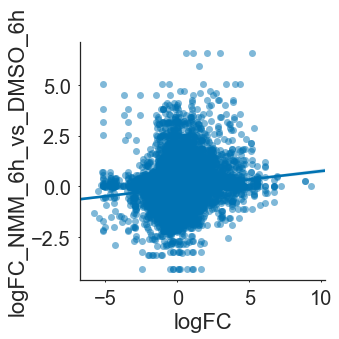

In [277]:
sns.lmplot(
    x='logFC',
    y='logFC_NMM_6h_vs_DMSO_6h',
    data=zm_at_nmm_v_cntrl_res,
    scatter_kws=dict(alpha=0.5)
)
plt.show()

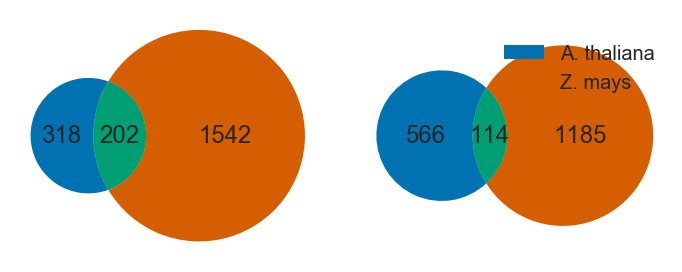

In [284]:
at_with_homologs = set(zm_at_nmm_v_cntrl_res.gene_id_athaliana)
zm_upreg_at_homologs = set(
    zm_at_nmm_v_cntrl_res[(zm_at_nmm_v_cntrl_res.logFC > 1) &
                          (zm_at_nmm_v_cntrl_res.FDR < 0.05)].gene_id_athaliana)
at_upreg = set(
    zm_at_nmm_v_cntrl_res[(zm_at_nmm_v_cntrl_res.logFC_NMM_6h_vs_DMSO_6h > 1) &
                          (zm_at_nmm_v_cntrl_res.PPLR_NMM_6h_vs_DMSO_6h > 0.9)].gene_id_athaliana)
zm_downreg_at_homologs = set(
    zm_at_nmm_v_cntrl_res[(zm_at_nmm_v_cntrl_res.logFC < -1) &
                          (zm_at_nmm_v_cntrl_res.FDR < 0.05)].gene_id_athaliana)
at_downreg = set(
    zm_at_nmm_v_cntrl_res[(zm_at_nmm_v_cntrl_res.logFC_NMM_6h_vs_DMSO_6h < -1) &
                          (zm_at_nmm_v_cntrl_res.PPLR_NMM_6h_vs_DMSO_6h < 0.1)].gene_id_athaliana)

fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
v = vn.venn2(
    [at_upreg, zm_upreg_at_homologs],
    set_labels=['', ''],
    set_colors=pal[:-2],
    ax=ax[0]
)
v.get_patch_by_id('11').set_color(pal[2])
for patch in v.patches:
    patch.set_alpha(1)
v = vn.venn2(
    [at_downreg, zm_downreg_at_homologs],
    set_labels=['', ''],
    set_colors=pal[:-2],
    ax=ax[1]
)
v.get_patch_by_id('11').set_color(pal[2])
for patch in v.patches:
    patch.set_alpha(1)
ax[1].bar(0, 0, 0, color=pal[0], label='A. thaliana')
ax[1].bar(0, 0, 0, color=pal[1], label='Z. mays')
ax[1].legend()
plt.tight_layout()
plt.savefig('zmays_athaliana_nmm_vnn.svg')
plt.show()

In [285]:
p_val = stats.hypergeom.sf(
    len(zm_upreg_at_homologs.intersection(at_upreg)) - 1,
    len(at_with_homologs),
    len(zm_upreg_at_homologs),
    len(at_upreg)
)
print(p_val)

3.94640821941e-66


In [286]:
p_val = stats.hypergeom.sf(
    len(zm_downreg_at_homologs.intersection(at_downreg)) - 1,
    len(at_with_homologs),
    len(zm_downreg_at_homologs),
    len(at_downreg)
)
print(p_val)

1.02516792659e-14


In [47]:
!wget ftp://ftp.ensemblgenomes.org/pub/plants/release-39/fasta/zea_mays/dna/Zea_mays.AGPv4.dna.toplevel.fa.gz

--2018-07-12 13:20:00--  ftp://ftp.ensemblgenomes.org/pub/plants/release-39/fasta/zea_mays/dna/Zea_mays.AGPv4.dna.toplevel.fa.gz
           => ‘Zea_mays.AGPv4.dna.toplevel.fa.gz’
Resolving ftp.ensemblgenomes.org (ftp.ensemblgenomes.org)... 193.62.197.94
Connecting to ftp.ensemblgenomes.org (ftp.ensemblgenomes.org)|193.62.197.94|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/plants/release-39/fasta/zea_mays/dna ... done.
==> SIZE Zea_mays.AGPv4.dna.toplevel.fa.gz ... 631368382
==> PASV ... done.    ==> RETR Zea_mays.AGPv4.dna.toplevel.fa.gz ... done.
Length: 631368382 (602M) (unauthoritative)

Zea_mays.AGPv4.dna. 100%[===================>] 602.12M  9.47MB/s    in 26s     

2018-07-12 13:20:26 (23.4 MB/s) - ‘Zea_mays.AGPv4.dna.toplevel.fa.gz’ saved [631368382]



In [48]:
!wget ftp://ftp.ensemblgenomes.org/pub/plants/release-39/gtf/zea_mays/Zea_mays.AGPv4.39.gtf.gz

--2018-07-12 13:21:16--  ftp://ftp.ensemblgenomes.org/pub/plants/release-39/gtf/zea_mays/Zea_mays.AGPv4.39.gtf.gz
           => ‘Zea_mays.AGPv4.39.gtf.gz’
Resolving ftp.ensemblgenomes.org (ftp.ensemblgenomes.org)... 193.62.197.94
Connecting to ftp.ensemblgenomes.org (ftp.ensemblgenomes.org)|193.62.197.94|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/plants/release-39/gtf/zea_mays ... done.
==> SIZE Zea_mays.AGPv4.39.gtf.gz ... 29651902
==> PASV ... done.    ==> RETR Zea_mays.AGPv4.39.gtf.gz ... done.
Length: 29651902 (28M) (unauthoritative)

Zea_mays.AGPv4.39.g 100%[===================>]  28.28M  42.8MB/s    in 0.7s    

2018-07-12 13:21:17 (42.8 MB/s) - ‘Zea_mays.AGPv4.39.gtf.gz’ saved [29651902]



In [113]:
%%bash
source activate cgat_python2

cgat gtf2gtf --method=merge-transcripts --filter=proteincoding \
  -I Zea_mays.AGPv4.39.gtf \
  -L /dev/null |
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' |
sort -k1,1 -k2,2n > genes.bed

In [115]:
%%bash
source activate jupyter_python3

join -j 1 -t $'\t' <( 
    bedtools intersect -sorted -c -s -F 1 \
      -a genes.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{print $4,$7,$7/($3-$2)*1000}') \
           <(
    bedtools intersect -sorted -c -S -F 1 \
      -a genes.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{print $4,$7,$7/($3-$2)*1000}') \
    > genic_g4_counts.tsv

In [116]:
!head genic_g4_counts.tsv

Zm00001d027230	8	1.4417	11	1.98234
Zm00001d027231	6	1.23967	12	2.47934
Zm00001d027232	0	0	0	0
Zm00001d027233	9	1.35176	2	0.300391
Zm00001d027234	1	0.946074	1	0.946074
Zm00001d027235	1	2.0202	0	0
Zm00001d027236	0	0	0	0
Zm00001d027239	6	2.70514	9	4.05771
Zm00001d027240	4	0.627845	9	1.41265
Zm00001d027242	4	0.737327	10	1.84332


In [103]:
%%bash
source activate cgat_python2
cgat gtf2gtf --method=exons2introns --filter=proteincoding \
  -I Zea_mays.AGPv4.39.gtf \
  -L /dev/null | \
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' |
sort -k1,1 -k2,2n > introns.bed

cgat gtf2gtf --method=merge-exons --filter=proteincoding \
  -I Zea_mays.AGPv4.39.gtf \
  -L /dev/null | \
awk -v OFS='\t' '{print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' |
sort -k1,1 -k2,2n > exons.bed

cgat gtf2gtf --method="merge-exons" --filter="proteincoding" --mark-utr \
  -I Zea_mays.AGPv4.39.gtf \
  -L /dev/null | \
awk -v OFS='\t' '$3 == "CDS" {print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' |
sort -k1,1 -k2,2n > cds.bed

cgat gtf2gtf --method="merge-exons" --filter="proteincoding" --mark-utr \
  -I Zea_mays.AGPv4.39.gtf \
  -L /dev/null | \
awk -v OFS='\t' '$3 == "UTR5" {print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' |
sort -k1,1 -k2,2n > utr5.bed

cgat gtf2gtf --method="merge-exons" --filter="proteincoding" --mark-utr \
  -I Zea_mays.AGPv4.39.gtf \
  -L /dev/null | \
awk -v OFS='\t' '$3 == "UTR3" {print $1, $4 - 1, $5, $10, ".", $7}' | sed 's/[";]//g' |
sort -k1,1 -k2,2n > utr3.bed

join -j 1 -t $'\t' <( 
    bedtools intersect -sorted -c -s \
      -a exons.bed\
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i]+1)*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -sorted -c -S \
      -a exons.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./exonic_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -sorted -c -s \
      -a introns.bed\
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -sorted -c -S \
      -a introns.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./intronic_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -sorted -c -s \
      -a cds.bed\
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -sorted -c -S \
      -a cds.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./cds_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -sorted -c -s \
      -a utr5.bed\
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -sorted -c -S \
      -a utr5.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./utr5_g4_counts.tsv

join -j 1 -t $'\t' <( 
    bedtools intersect -sorted -c -s \
      -a utr3.bed\
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
           <(
    bedtools intersect -sorted -c -S \
      -a utr3.bed \
      -b ../plant_genomes_g4_content/Zea_mays.AGPv4.dna.toplevel_2t.bed | \
    awk -v OFS='\t' '{count[$4]+=$7; len[$4]+=($3-$2)} END \
                     {for (i in count) {print i,count[i],count[i]/(len[i])*1000}}' | \
    sort -k1,1d) \
    > ./utr3_g4_counts.tsv

In [117]:
g4_counts = pd.read_table('genic_g4_counts.tsv',
                          sep='\t',
                          names=['gene_id', 'coding_g4', 'coding_g4_dens',
                                 'template_g4', 'template_g4_dens'])
g4_counts_exon = pd.read_table(
    'exonic_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'exon_coding_g4', 'exon_coding_g4_dens',
           'exon_template_g4', 'exon_template_g4_dens']
)
g4_counts_intron = pd.read_table(
    'intronic_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'intron_coding_g4', 'intron_coding_g4_dens',
           'intron_template_g4', 'intron_template_g4_dens']
)
g4_counts_cds = pd.read_table(
    'cds_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'cds_coding_g4', 'cds_coding_g4_dens',
           'cds_template_g4', 'cds_template_g4_dens']
)
g4_counts_utr5 = pd.read_table(
    'utr5_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'utr5_coding_g4', 'utr5_coding_g4_dens',
           'utr5_template_g4', 'utr5_template_g4_dens']
)
g4_counts_utr3 = pd.read_table(
    'utr3_g4_counts.tsv',
    sep='\t',
    names=['gene_id',
           'utr3_coding_g4', 'utr3_coding_g4_dens',
           'utr3_template_g4', 'utr3_template_g4_dens']
)
g4_counts_exon_intron = g4_counts_exon.merge(g4_counts_intron, how='outer')#.fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_cds, how='outer')#.fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_utr5, how='outer')#.fillna(0)
g4_counts_exon_intron = g4_counts_exon_intron.merge(g4_counts_utr3, how='outer')#.fillna(0)
nmm_g4_tot = (zm_nmm_v_cntrl_res.reset_index()
                                .merge(g4_counts, left_on='gene_id_zmays', right_on='gene_id')
                                .merge(g4_counts_exon_intron, on='gene_id')
                                .dropna())
nmm_g4_tot.head(n=10)

,gene_id_zmays,logFC,logCPM,LR,PValue,FDR,ERR2193270,ERR2193271,ERR2193272,ERR2193273,...,cds_template_g4,cds_template_g4_dens,utr5_coding_g4,utr5_coding_g4_dens,utr5_template_g4,utr5_template_g4_dens,utr3_coding_g4,utr3_coding_g4_dens,utr3_template_g4,utr3_template_g4_dens
158,GRMZM5G800101,0.272991,0.264332,0.272027,0.601975,0.806594,-0.160624,0.813486,0.141813,-0.687116,...,1.0,0.653595,4.0,1.63867,0.0,0.00000,0.0,0.000000,0.0,0.000000
162,GRMZM5G818111,1.468893,-0.573377,6.685609,0.009719,0.062308,0.259543,0.208098,-1.080142,-0.983506,...,1.0,1.934240,1.0,2.71003,0.0,0.00000,0.0,0.000000,0.0,0.000000
176,GRMZM5G862955,0.479084,5.281168,2.429646,0.119060,0.337499,5.390826,5.941700,4.709278,5.331227,...,1.0,0.729395,2.0,2.81294,3.0,4.21941,1.0,0.657030,3.0,1.971090
189,Zm00001d000001,3.437444,2.027165,19.910735,0.000008,0.000214,0.251127,3.883353,2.513622,-0.404805,...,6.0,3.206840,1.0,7.93651,0.0,0.00000,1.0,3.636360,0.0,0.000000
190,Zm00001d000002,0.406640,1.147236,0.896083,0.343834,0.610209,0.571636,1.583368,1.376690,0.566231,...,0.0,0.000000,0.0,0.00000,0.0,0.00000,1.0,0.426621,0.0,0.000000
191,Zm00001d000004,-0.388686,4.142860,2.296056,0.129703,0.354946,3.683546,4.181799,3.818607,4.582411,...,0.0,0.000000,1.0,7.57576,2.0,15.15150,0.0,0.000000,0.0,0.000000
192,Zm00001d000005,0.111895,2.681232,0.136376,0.711911,0.868552,2.223108,3.091214,2.656440,2.406164,...,8.0,3.870340,0.0,0.00000,2.0,15.38460,0.0,0.000000,0.0,0.000000
193,Zm00001d000006,-1.078783,3.823021,1.439098,0.230285,0.492092,1.089293,0.849362,4.471891,4.831709,...,2.0,2.962960,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000
194,Zm00001d000008,-2.012596,2.534771,5.019038,0.025070,0.122797,-0.201922,-1.793999,2.412008,3.346246,...,2.0,2.962960,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000
195,Zm00001d000011,-0.350357,3.434751,0.473486,0.491388,0.732323,3.735309,3.450333,2.159392,2.853109,...,4.0,3.842460,1.0,1.06610,6.0,6.39659,0.0,0.000000,1.0,0.325839


In [118]:
nmm_g4_tot['upreg'] = ((nmm_g4_tot.FDR < 0.05) &
                       (nmm_g4_tot.logFC > 1))
nmm_g4_tot['downreg'] = ((nmm_g4_tot.FDR < 0.05) &
                         (nmm_g4_tot.logFC < -1))
nmm_g4_tot['notDE'] = ~nmm_g4_tot.upreg & ~nmm_g4_tot.downreg
nmm_g4_tot['cond'] = nmm_g4_tot[['upreg', 'downreg', 'notDE']].idxmax(1)

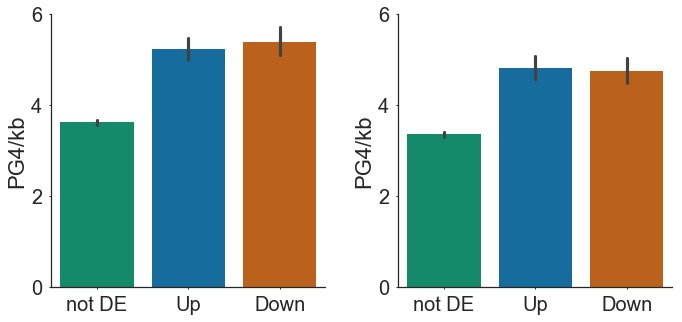

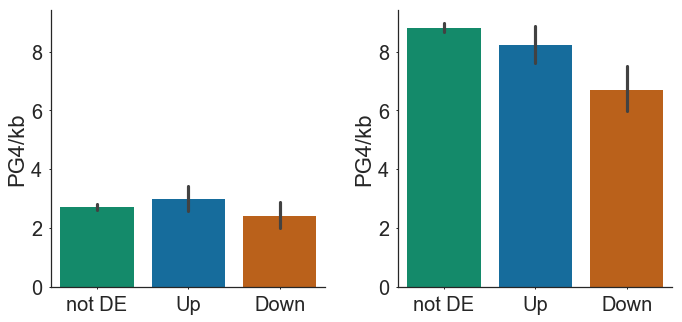

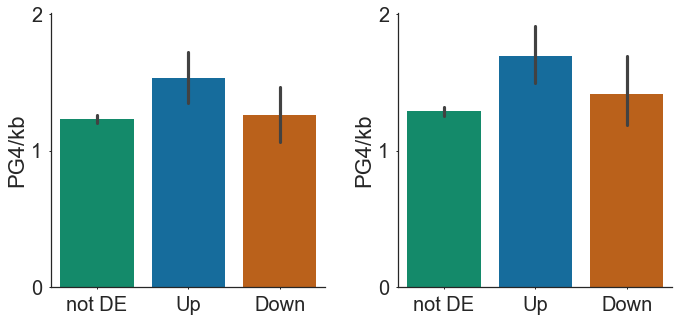

In [263]:
for region in ['cds_', 'utr5_', 'intron_']:
    nmm_g4_long = pd.melt(
        nmm_g4_tot.drop_duplicates(subset=['gene_id']),
        id_vars=['gene_id', 'logFC', 'cond', 'strong_cond'],
        value_vars=['{}coding_g4_dens'.format(region), '{}template_g4_dens'.format(region)],
        var_name='strand', value_name='g4_density')
    g = sns.factorplot(x='cond',
                       y='g4_density',
                       col='strand',
                       kind='bar',
                       order=['notDE', 'upreg', 'downreg'],
                       data=nmm_g4_long,
                       legend=False,
                       palette=[pal[2], pal[0], pal[1]],
                       size=5)
    for ax in g.axes.ravel():
        ax.set_xticklabels(['not DE', 'Up', 'Down'])
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('PG4/kb')
        m = int(ax.get_ylim()[1]) + 1
        if m <= 6:
            yticks = np.arange(m)
        else:
            yticks = np.arange(0, m, 2)
        ax.set_yticks(yticks)
    plt.tight_layout()
    plt.savefig('{}zeamays_pg4_density.svg'.format(region))
    plt.show()

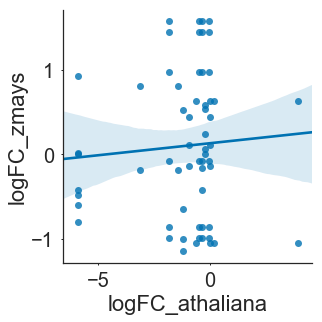

In [167]:
zm_ext = zm_at_nmm_v_cntrl_res[zm_at_nmm_v_cntrl_res.gene_id_athaliana.isin(extensins['AGI Identifier'])]
sns.lmplot(x='logFC_athaliana', y='logFC_zmays', data=zm_ext)